# Model Pergerakan Harga Saham Binomial Emiten WIKA.JK
### Tugas Besar Pemodelan, Simulasi, dan Optimasi

Anggota Kelompok:
1. Ariq Heritsa Maalik (1305213031)
2. Nadya Khairani (1305210069)
3. Muhammad Baari Adli (1305213081)

In [493]:
# !pip install yfinance
# !pip install pandas-datareader
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

In [494]:
ywika = yf.Ticker('WIKA.JK')

# get historical market data
overall = ywika.history(start='2021-06-30', end='2022-12-30')
hist = ywika.history(start='2021-06-30', end='2022-07-02')
actual = ywika.history(start='2022-07-01', end='2022-12-30')

hist.to_csv('hist.csv')
actual.to_csv('actual.csv')

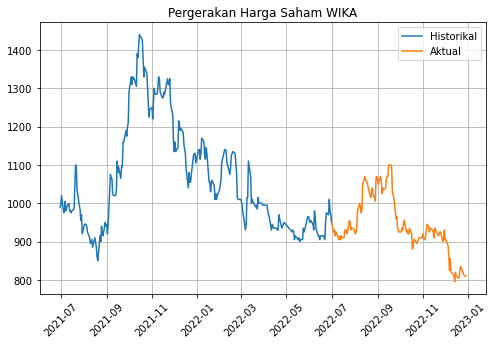

In [508]:
fig,ax = plt.subplots(1, figsize=(8,5))
ax.plot(hist['Close'], label='Historikal')
ax.plot(actual['Close'], label='Aktual')

plt.title('Pergerakan Harga Saham WIKA')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

## Persiapan Simulasi

In [496]:
sim_days = len(hist) // 2
simulations = 1000

r = 0.055
T = 1
dt = T / sim_days

### Parameter Model CRR

In [497]:
log_stocks = np.log(np.array([hist.Close[i] for i in range(0,int(len(hist) / 2))]))

sig_crr = np.sqrt(np.std(log_stocks) / 1) # volatilitas harga saham
up_crr = np.exp(sig_crr * np.sqrt(dt))
down_crr = 1 / up_crr
p_crr = (np.exp(r * dt) - down_crr) / (up_crr - down_crr)

print('variansi log saham =', np.std(log_stocks))
print('volatilitas harga saham =', sig_crr)
print('up =', up_crr)
print('down =', down_crr)
print('p =', p_crr)

variansi log saham = 0.14211391422664457
volatilitas harga saham = 0.3769799918120915
up = 1.034719281993208
down = 0.9664456992370651
p = 0.4980729104401249


### Parameter Metode Empiris

In [498]:
hist['return'] = [hist.Close[i] / hist.Close[i-1] for i in range(1,len(hist))]+[0]
ret = np.array(hist['return'][0:int(len(hist) / 2)])

up_empirical = np.mean(ret[ret > 1])
down_empirical = np.mean(ret[ret <= 1])
p_empirical = len(ret[ret > 1]) / len(ret)
avret = np.mean(ret)

print('mean, std up', np.mean(ret[ret > 1]), np.std(ret[ret > 1]))
print('mean, std down', np.mean(ret[ret <= 1]), np.std(ret[ret <= 1]))

print('up', up_empirical)
print('down', down_empirical)
print('p', p_empirical)
# sigm=(ret-avret)**2

mean, std up 1.0287936833368108 0.027155831967393164
mean, std down 0.9823289256927519 0.015622886117444479
up 1.0287936833368108
down 0.9823289256927519
p 0.4016393442622951


### Faktor Perubahan Harga pada Model Empiris

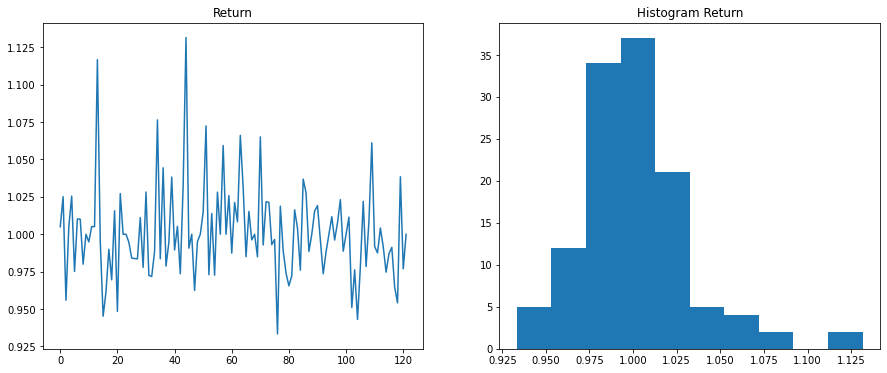

In [499]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(ret)
ax2.hist(ret, bins=10)

ax1.set_title('Return')
ax2.set_title('Histogram Return')

plt.show()

## Membuat Pohon Binomial Saham

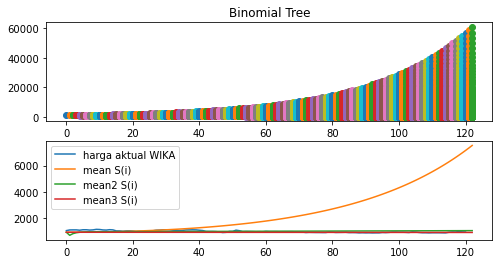

In [500]:
# Membuat pohon Binomial Saham
So = hist.Close[-1]
sig = sig_crr
dt = 1 / sim_days
u = up_crr
d = down_crr
p = p_crr

fig,ax = plt.subplots(2,figsize=(8,4))
price = np.zeros((sim_days+1,sim_days+1), float)
mean_si = np.zeros((sim_days+1), float)
mean2_si = np.zeros((sim_days+1), float)
mean3_si = np.zeros((sim_days+1), float)
mean_si[0] = So
mean2_si[0] = So
mean3_si[0] = So
price[0, sim_days] = So
ax[0].scatter(0, price[0, sim_days])
ax[1].plot(range(len(hist.Close[int(len(hist)/2)+1:-1])), hist.Close[int(len(hist)/2)+1:-1], label='harga aktual WIKA')

for i in range(1,sim_days+1):
  for j in reversed(range(i+1)):
    price[j,i] = So*u**(j)*d**(i-j)

  ax[0].scatter([i for k in range(len(price[0:i+1,i]))], price[0:i+1,i])
  mean_si[i] = np.mean(price[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  
  mean2_si[i] = np.sum(price[0:i+1,i]*prob) 
  mean3_si[i] = So*u**(i*p)*d**(i-i*p)

ax[0].set_title("Binomial Tree")
ax[1].plot(mean_si, label='mean S(i)')
ax[1].plot(mean2_si, label='mean2 S(i)')
ax[1].plot(mean3_si, label='mean3 S(i)')
plt.legend()

## Simulation

### Model CRR

In [501]:
So = hist.Close[-1]
u = up_crr
d = down_crr
p = p_crr
smt = []

for k in range(simulations):
  s = So
  sv = [s]
  for i in range(sim_days):
    x = np.random.binomial(i, p)
    s = So * np.power(u, x) * np.power(d, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt = [k for k in smt[1:][:]] 
averages = [np.mean(x) * 2 for x in smt]
avg = np.mean(averages)
std = np.std(averages)
confidence_interval = [avg - 1.96 * std, avg + 1.96 * std]

print('selang kepercayaan 95% =', confidence_interval)

selang kepercayaan 95% = [1858.8063890273627, 2046.4138430284727]


### Visualisasi

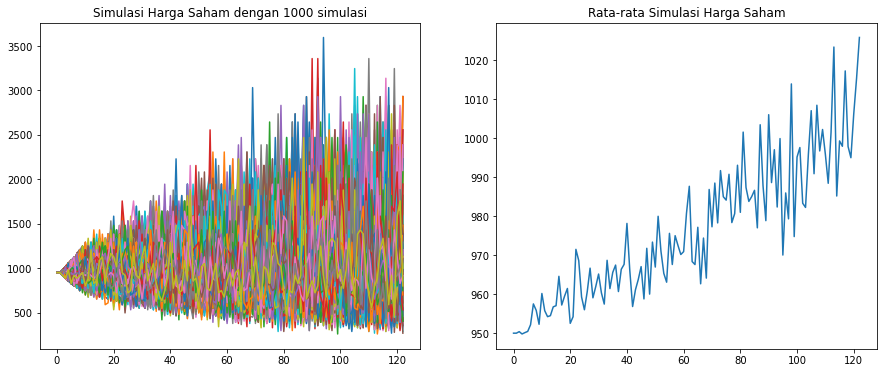

In [502]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the paths
[ax1.plot(k) for k in smt]

# Average path of stock prices
smean_crr = np.mean(np.array(smt), axis=0)

ax2.plot(smean_crr)

ax1.title.set_text(f'Simulasi Harga Saham dengan {simulations} simulasi')
ax2.title.set_text('Rata-rata Simulasi Harga Saham')
plt.show()

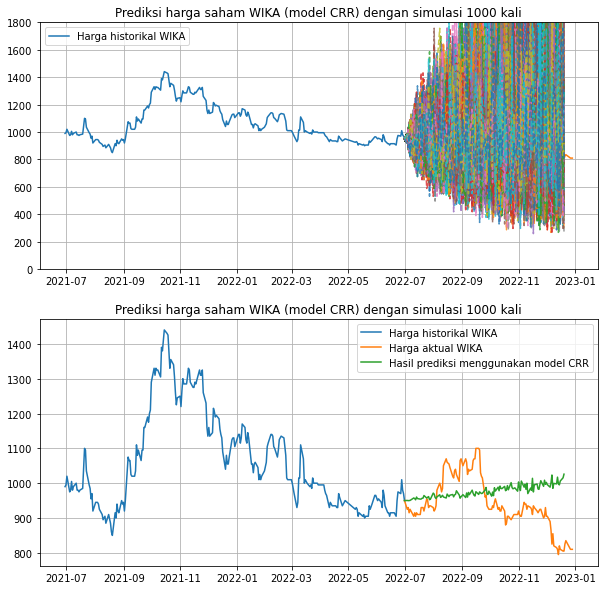

In [503]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(hist['Close'], label='Harga historikal WIKA')
ax1.plot(actual['Close'])
[ax1.plot(pd.Series(k[1:], index=actual.index[:-7]), alpha=0.8, linestyle='--') for k in smt]

ax2.plot(hist['Close'], label='Harga historikal WIKA')
ax2.plot(actual['Close'], label='Harga aktual WIKA')
ax2.plot(pd.Series(smean_crr[1:], index=actual.index[:-7]), label='Hasil prediksi menggunakan model CRR')

ax1.set_title(f'Prediksi harga saham WIKA (model CRR) dengan simulasi {simulations} kali')
ax2.set_title(f'Prediksi harga saham WIKA (model CRR) dengan simulasi {simulations} kali')
ax1.set_ylim(0, 1800)

ax1.grid()
ax2.grid()

ax1.legend()
ax2.legend()
plt.show()

### Metode Empiris

In [504]:
So = hist.Close[-1]
u = up_empirical
d = down_empirical
p = p_empirical
smt = []

for k in range(simulations):
  s = So
  sv = [s]
  for i in range(sim_days):
    x = np.random.binomial(i, p)
    s = So * np.power(u, x) * np.power(d, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt = [k for k in smt[1:][:]] 
averages = [np.mean(x) * 2 for x in smt]
avg = np.mean(averages)
std = np.std(averages)
confidence_interval = [avg - 1.96 * std, avg + 1.96 * std]

print('selang kepercayaan 95% =', confidence_interval)

selang kepercayaan 95% = [1950.4837016751283, 2083.7294477167106]


### Visualisasi

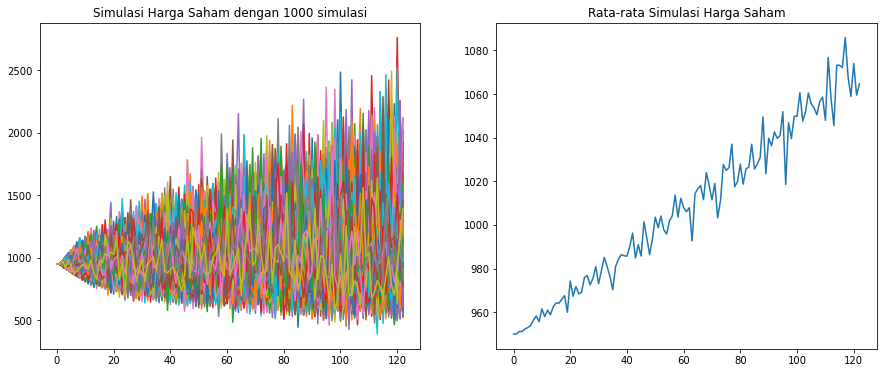

In [505]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the paths
[ax1.plot(k) for k in smt]

# Average path of stock prices
smean_empirical = np.mean(np.array(smt), axis=0)

ax2.plot(smean_empirical)

ax1.title.set_text(f'Simulasi Harga Saham dengan {simulations} simulasi')
ax2.title.set_text('Rata-rata Simulasi Harga Saham')
plt.show()

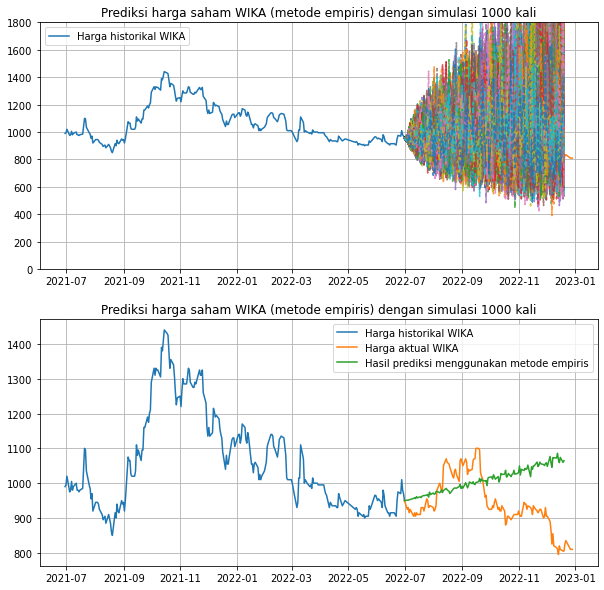

In [506]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(hist['Close'], label='Harga historikal WIKA')
ax1.plot(actual['Close'])
[ax1.plot(pd.Series(k[1:], index=actual.index[:-7]), alpha=0.8, linestyle='--') for k in smt]

ax2.plot(hist['Close'], label='Harga historikal WIKA')
ax2.plot(actual['Close'], label='Harga aktual WIKA')
ax2.plot(pd.Series(smean_empirical[1:], index=actual.index[:-7]), label='Hasil prediksi menggunakan metode empiris')

ax1.set_title(f'Prediksi harga saham WIKA (metode empiris) dengan simulasi {simulations} kali')
ax2.set_title(f'Prediksi harga saham WIKA (metode empiris) dengan simulasi {simulations} kali')
ax1.set_ylim(0, 1800)

ax1.grid()
ax2.grid()

ax1.legend()
ax2.legend()

plt.show()

## Perbandingan Model CRR dan Metode Empiris

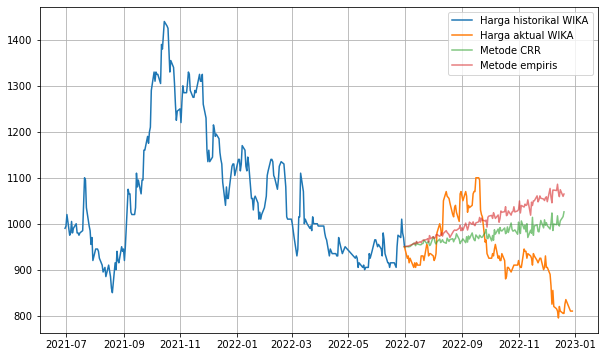

In [507]:
fig = plt.figure(figsize=(10, 6))

plt.plot(hist['Close'], label='Harga historikal WIKA')
plt.plot(actual['Close'], label='Harga aktual WIKA')

plt.plot(pd.Series(smean_crr[1:], index=actual.index[:-7]), label='Metode CRR', alpha=0.6)
plt.plot(pd.Series(smean_empirical[1:], index=actual.index[:-7]), label='Metode empiris', alpha=0.6)

plt.legend()
plt.grid()